# Exract the feature for the DB 

- `outputdict(:dict)`: Label level data, common to all measurements
- `table_data(:list of dict)`: all measurements data extracted from the file, one per measurement. Comprises array+numbers


## Various

#### scalar values 

Choose which columns are `ENUM`, most likely in the label level data. From Postgres >= 9.1 you can add new values to enum:

``` SQL
CREATE TYPE fruit AS ENUM ('orange', 'apple');
SELECT 'rasberry'::fruit; -- returns and error
ALTER TYPE fruit ADD VALUE 'rasberry';
SELECT 'rasberry'::fruit;
```

This should be done at DB level with sqlalchemy. 

__!! How to check if we need to insert new enum before insertion?__
 
#### vector values 

Insert in postgres as array : use `sqlalchemy.dialects.postgresql.ARRAY` (ARRAY datatype) from [SQLAlchemy 1.2 Documentation](http://docs.sqlalchemy.org/en/latest/dialects/postgresql.html?highlight=array#array-types)

#### date/time

convert to python datetime objects __DONE__


## Process

1. separate array and useful numbers from `table_data` **DONE** 
     - add `outputdict` to it **DONE** 

2. Extract geometrical coordinates and store as WKT represenation > > this should result in a PostGIS obgect, see connector docs. **DONE** 
    - most likely will be a string per measurement : Shapely objects **DONE** 
    - maybe geoalchemy-2 could insert geo type directly?

3. Resample spectrum data **DONE** 
    - arrange in a string > this should result in a PG array, see connector docs.
    - most likely will be a string per measurement
    - convert to sqlalchemy.types.ARRAY, will be inserted automatically.

4. Merge 1. , 2., 3. in an unique structure:
    - pandas.Dataframe?
    - geopandas
    - list of dict? maybe the best for heterogeneous values : scalar, sqlalchemy.types.ARRAY, shapely etc

In [1]:
# import from parent directory : this is NOT NICE! but, wathever...
import sys
import os 
sys.path.append("..")

import dotenv_loader
postgresql_connection_string = os.environ.get("DATABASE_URL")

In [41]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import pathlib
import pvl
from tqdm.notebook import tqdm

# from tqdm import tqdm
from osgeo import ogr
from datetime import datetime

# useful for displaying html, images and so on
from IPython.display import display

In [3]:
# import local functions
import utils

In [4]:
import rich 
rich.inspect(utils,methods=True)

╭─ <module 'utils' from '/home/kidpixo/Documents/work/programs/europlanet-2024/ml/MESSENGER─╮
│         DATA_QUALITY_INDEX = [                                                            │
│                                  (                                                        │
│                                      'Dark Scan',                                         │
│                                      {                                                    │
│                                          '0': 'shutter not engaged',                      │
│                                          '1:': 'shutter engaged'                          │
│                                      }                                                    │
│                                  ),                                                       │
│                                  (                                                        │
│                                      'Temperature 1',                                     │
│                                      {                                                    │
│                                          '0': 'Temperature does not exceed 15 deg C       │
│                              threshold.',                                                 │
│                                          '1': 'Temperature exceeds 15 deg C threshold but │
│                              less than 25 deg C threshold.',                              │
│                                          '2': 'Temperature exceeds 25 deg C threshold but │
│                              less than 40 deg C threshold.',                              │
│                                          '3': 'Temperature exceeds 40 deg C threshold.'   │
│                                      }                                                    │
│                                  ),                                                       │
│                                  (                                                        │
│                                      'Temperature 2',                                     │
│                                      {                                                    │
│                                          '0': 'Temperature does not exceed 15 deg C       │
│                              threshold.',                                                 │
│                                          '1': 'Temperature exceeds 15 deg C threshold but │
│                              less than 25 deg C threshold.',                              │
│                                          '2': 'Temperature exceeds 25 deg C threshold but │
│                              less than 40 deg C threshold.',                              │
│                                          '3': 'Temperature exceeds 40 deg C threshold.'   │
│                                      }                                                    │
│                                  ),                                                       │
│                                  (                                                        │
│                                      'Grating Temperature',                               │
│                                      {                                                    │
│                                          '0': 'Temperature does not exceed 15 deg C       │
│                              threshold.',                                                 │
│                                          '1': 'Temperature exceeds 15 deg C threshold but │
│                              less than 25 deg C threshold.',                              │
│                                          '2': 'Temperature exceeds 25 deg C threshold but │
│                              less than 40 deg C threshold.',                              │
│                                          '3': 'Tem

In [5]:
# this is only useful during development
import importlib
utils = importlib.reload(utils)

In [6]:
wav_grid_2nm = utils.Wavelenght('uniform grid 2nm',260,1052,2)
wav_grid_10nm = utils.Wavelenght('uniform grid 10nm',260,1052,10)
print(f' wav_grid_2nm = {wav_grid_2nm}')
print(f'wav_grid_10nm = {wav_grid_10nm}')

 wav_grid_2nm = Wavelenght(name="uniform grid 2nm",start=260,end=1052,res=2)
wav_grid_10nm = Wavelenght(name="uniform grid 10nm",start=260,end=1052,res=10)


In [7]:
print('-'*30)
wav_instance = wav_grid_2nm
for wcentr in range(300,1000,100):
    wcentr_index = wav_instance.nearest_index(wcentr)
    print(f'{wcentr=} - {wcentr_index=}')
    wini, wend = wcentr-5,wcentr+5
    wini_ind, wend_ind = wav_instance.nearest_index(wini),wav_instance.nearest_index(wend)
    print(f'{wini=} > {wend=}')
    print(f'photom_iof_sp_2nm[{wini_ind}:{wend_ind}]')
    print('-'*30)

------------------------------
wcentr=300 - wcentr_index=20
wini=295 > wend=305
photom_iof_sp_2nm[17:22]
------------------------------
wcentr=400 - wcentr_index=70
wini=395 > wend=405
photom_iof_sp_2nm[67:72]
------------------------------
wcentr=500 - wcentr_index=120
wini=495 > wend=505
photom_iof_sp_2nm[117:122]
------------------------------
wcentr=600 - wcentr_index=170
wini=595 > wend=605
photom_iof_sp_2nm[167:172]
------------------------------
wcentr=700 - wcentr_index=220
wini=695 > wend=705
photom_iof_sp_2nm[217:222]
------------------------------
wcentr=800 - wcentr_index=270
wini=795 > wend=805
photom_iof_sp_2nm[267:272]
------------------------------
wcentr=900 - wcentr_index=320
wini=895 > wend=905
photom_iof_sp_2nm[317:322]
------------------------------


In [8]:
### OUTPUTS

outputkeys = [
#  u'PDS_VERSION_ID',
#  u'RECORD_TYPE',
#  u'RECORD_BYTES',
#  u'FILE_RECORDS',
 u'PRODUCT_ID',
 u'PRODUCT_VERSION_ID',
 u'PRODUCT_CREATION_TIME',
#  u'PRODUCT_TYPE',
#  u'SOFTWARE_NAME',
#  u'SOFTWARE_VERSION_ID',
#  u'INSTRUMENT_HOST_NAME',
#  u'INSTRUMENT_NAME',
#  u'INSTRUMENT_ID',
 u'DETECTOR_ID',
#  u'DATA_SET_ID',
 u'STANDARD_DATA_PRODUCT_ID',
 u'MISSION_PHASE_NAME',
 u'TARGET_NAME',
 u'SITE_ID',
 u'START_TIME',
 u'STOP_TIME',
 u'SPACECRAFT_CLOCK_START_COUNT',
 u'SPACECRAFT_CLOCK_STOP_COUNT',
#  u'^TABLE',   
]

### SELECT the keyword to retain for the output structure for SINGLE spectrum
table_data_outkeys = [
 'ACROSS_TRACK_FOOTPRINT_SIZE',
 'ALONG_TRACK_FOOTPRINT_SIZE',
# 'BINNING',
#          'CHANNEL_WAVELENGTHS', # ARRAY
# 'DARK_FREQ',
 'DATA_QUALITY_INDEX',
 'EMISSION_ANGLE',
# 'END_PIXEL',
 'INCIDENCE_ANGLE',
 'INT_COUNT',
# 'INT_TIME',
#          'IOF_NOISE_SPECTRUM_DATA', # ARRAY
#          'IOF_SPECTRUM_DATA', # ARRAY
 'PACKET_SUBSECONDS',
 'PHASE_ANGLE',
#          'PHOTOM_IOF_NOISE_SPECTRUM_DATA', # ARRAY
#          'PHOTOM_IOF_SPECTRUM_DATA', # ARRAY
 'SC_TIME',
 'SOFTWARE_VERSION',
 'SOLAR_DISTANCE',
# 'SPARE_1',
# 'SPARE_2',
# 'SPARE_3',
# 'SPARE_4',
# 'SPARE_5'
 'SPECTRUM_MET',
 'SPECTRUM_NUMBER',
 'SPECTRUM_SUBSECONDS',
 'SPECTRUM_UTC_TIME',
# 'START_PIXEL',
#          'TARGET_LATITUDE_SET',
#          'TARGET_LONGITUDE_SET',
 'TEMP_2',
] + outputkeys + [
# DATA_QUALITY_INDEX
 'Dark_Scan',
 'Temperature_1',
 'Temperature_2',
 'Grating_Temperature',
 'Anomalous_Pixels',
 'Partial_Data',
 'Saturation',
 'Low_Signal_Level',
 'Low_VIS_Wavelength_Uncertainty',
 'High_VIS_Wavelength_Uncertainty',
 'UVVS_Operating',
 'UVVS_Noise_Spike',
 'SPICE_Version_Epoch',
 'Dark_Saturation',
#  'SpareO',
#  'SpareP',
] + [
    # spectral data
    'photom_iof_sp_2nm',
    'iof_sp_2nm'
    ] + [
# geometry
    'center', 'fov']

### INPUTS

##### test data
# base path untile messmas_2101
rootdir_input = '../../data/raw/test/mess-e_v_h-mascs-3-virs-cdr-caldata-v1/messmas_2101/'
# # useful to limit to a single ORBIT
# datadir_input = 'data/ddr/orb/virs/mascs20110717'
# this include all mission pahses!!!
datadir_input = 'data/ddr/'

### WARNING ###
# check the location of FMT file! local symlink is OK
### WARNING ###
### ToDo : Use a cached value, we'll be using the same file over and over, no need to read it everytime.
# Example :
# create an empy dicty
format_files = {}

### PROCESS
root_path = pathlib.Path(rootdir_input)
datadir_path = root_path / datadir_input

Filter only `virsvd*.lbl` files, only VIRS detector.  

In [9]:
### FIND THE FILES: this could take long time
lbl_files = list(datadir_path.rglob('virsvd*.lbl'))
pd.DataFrame(
    [{
      'phase':e.parent.parent.parent.parent.name,
      'detector':e.parent.parent.parent.name,
      'orbit':e.parent.parent.name,
      'filename':e.stem,
      'size (MB): ':e.with_suffix('.dat').stat().st_size/2**20} 
     for n,e in enumerate(lbl_files)
    ]
).round(2)

,phase,detector,orbit,filename,size (MB):
0,ob2,virs,mascs20130220,virsvd_ob2_13051_143720,1.13
1,ob4,virs,mascs20141222,virsvd_ob4_14356_141214,6.89
2,orb,virs,mascs20120204,virsvd_orb_12035_083953,5.96
3,orb,virs,mascs20110812,virsvd_orb_11224_214005,4.20


[New Issue · planetarypy/pvl](https://github.com/planetarypy/pvl/issues/new?assignees=&labels=&template=bug-report---.md&title=)

**Describe the bug**
PVL doesn't honor the `^STRUCTURE` tag and silently goes on.
From [PDS-SBN: How To Approach a PDS Data Set](https://pds-smallbodies.astro.umd.edu/howto/understand.shtml):

label/: This directory contains label include files - the repetitive parts of labels (the data structure, typically) extracted to simplify either the labels themselves or configuration management or both. If you see a line in a label that looks like this:
`^STRUCTURE = "FILE.FMT"`
then you should find the "FILE.FMT" file in the label directory. 

**To Reproduce**

In my case, I'm working with an `OBJECT  = TABLE`
A minimal example :

```bash
# get a minimal dataset 
git clone https://github.com/epn-ml/MESSENGER-Mercury-Surface-Cassification-Unsupervised_DLR
cd MESSENGER-Mercury-Surface-Cassification-Unsupervised_DLR/data/raw/test/mess-e_v_h-mascs-3-virs-cdr-caldata-v1/messmas_2101/data/ddr/ob2/virs/mascs20130220/vis
```
python code : 

```python
import pvl
label = pvl.load(str('virsvd_ob2_13051_143720.lbl'))

```

**Expected behavior**
A clear and concise description of what you expected to happen.

**Error logs or terminal captures**
If applicable, add examples to help explain your problem.

**Your Environment (please complete the following information):**
 - OS: (e.g. macOS, Linux, etc.)
 - Environment information: (e.g. Python version, etc.)
 - `pvl` Version (can find via `import pvl, print(pvl.__version__)`)

**Additional context**
Add any other context about the problem here.


In [10]:
### Define the file to work on
lbl_file = lbl_files[0]
print(f'{lbl_file=}')

lbl_file=PosixPath('../../data/raw/test/mess-e_v_h-mascs-3-virs-cdr-caldata-v1/messmas_2101/data/ddr/ob2/virs/mascs20130220/vis/virsvd_ob2_13051_143720.lbl')


In [11]:
### READ the label to search for the FMT
label = pvl.load(str(lbl_file))

fmt_location = root_path / 'label/' 

# # assign custom location for ^STRUCTURE VIRSVD.FMT
# if label['TABLE']['^STRUCTURE'] not in format_files :
#     format_files[label['TABLE']['^STRUCTURE']] = pvl.load(str(fmt_location / label['TABLE']['^STRUCTURE'].lower()))

# assign fmt from dict, if not present will be None
fmt = format_files.get(label['TABLE']['^STRUCTURE'])

# print(label['TABLE']['^STRUCTURE'])
# print(f'{fmt}')

outputdict = utils.dictextractor(outputkeys,label)

# for spacecraft_clock in ['SPACECRAFT_CLOCK_START_COUNT','SPACECRAFT_CLOCK_STOP_COUNT']:
#     outputdict[spacecraft_clock] =  float(outputdict[spacecraft_clock][2:])

print('outputdict content:')
headers = ["name", "type", "val"]
print(tabulate([(k,type(v).__name__,str(v)) for k,v in outputdict.items()], headers=headers, tablefmt="rst", numalign="right", floatfmt=".4f"))

outputdict content:
============================  ========  ===========================
name                          type      val
============================  ========  ===========================
PRODUCT_ID                    str       VIRSVD_OB2_13051_143720_DAT
PRODUCT_VERSION_ID            str       V1
PRODUCT_CREATION_TIME         datetime  2017-02-17 19:56:42+00:00
DETECTOR_ID                   str       VIRS
STANDARD_DATA_PRODUCT_ID      str       VIRSDVIS
MISSION_PHASE_NAME            str       MERCURY ORBIT YEAR 2
TARGET_NAME                   str       MERCURY
SITE_ID                       str       N/A
START_TIME                    datetime  2013-02-20 14:37:21+00:00
STOP_TIME                     datetime  2013-02-20 14:45:17+00:00
SPACECRAFT_CLOCK_START_COUNT  str       2/3695040.225
SPACECRAFT_CLOCK_STOP_COUNT   str       2/3695516.240
============================  ========  ===========================


In [14]:
### READ the actual file data with OGR

inDataSource = ogr.Open(str(lbl_file))
table = inDataSource.GetLayer()
print('FeatureCount : %s ' % table.GetFeatureCount())

# which spectra from the file?
table_data = []
layerDefinition = table.GetLayerDefn()
print(layerDefinition.GetFieldCount())

FeatureCount : 113 
33


In [16]:
for sp_id in tqdm(range(table.GetFeatureCount()), desc='Features'):
# for sp_id in range(table.GetFeatureCount()):
    data = {}
    for i in range(layerDefinition.GetFieldCount()):
        fielddef = layerDefinition.GetFieldDefn(i)
        fieldName = fielddef.GetName()
        fieldData = table[sp_id].GetField(fieldName)
        # transform List to numpy.array
        data[fieldName] = np.array(fieldData) if isinstance(fieldData, list) else fieldData
    fov_coord_extracted = utils.fov_coord_extractor(data,shapelyze=True, geoalchemy2ize=False ,srid=4326)
    if fov_coord_extracted:
        data.update(fov_coord_extracted) # OUTPUT : shapely objects dict.keys = ['center', 'fov']

        # add LABEL level data
        data.update(outputdict)
        data['SPECTRUM_UTC_TIME'] = datetime.strptime(data['SPECTRUM_UTC_TIME'].strip(), '%y%jT%H:%M:%S')
        data.update(utils.extract_data_quality_index(data) ) # OUTPUT = DATA_QUALITY_INDEX dict 
        data.update(utils.extract_regridded_sp(data,wav_grid_2nm.wavelenghts)) # OUTPUT dict.keys = ['photom_iof_sp_2nm', 'iof_sp_2nm']
        
        table_data.append(utils.dictextractor(table_data_outkeys,data))
    else:
        print('Nan in geoemtry {}:{}'.format(lbl_file.stem,sp_id))
        pass

Features:   0%|          | 0/113 [00:00<?, ?it/s]

Nan in geoemtry virsvd_ob2_13051_143720:0
Nan in geoemtry virsvd_ob2_13051_143720:1
Nan in geoemtry virsvd_ob2_13051_143720:93
Nan in geoemtry virsvd_ob2_13051_143720:94
Nan in geoemtry virsvd_ob2_13051_143720:95
Nan in geoemtry virsvd_ob2_13051_143720:96
Nan in geoemtry virsvd_ob2_13051_143720:97
Nan in geoemtry virsvd_ob2_13051_143720:98
Nan in geoemtry virsvd_ob2_13051_143720:99
Nan in geoemtry virsvd_ob2_13051_143720:100
Nan in geoemtry virsvd_ob2_13051_143720:101
Nan in geoemtry virsvd_ob2_13051_143720:102
Nan in geoemtry virsvd_ob2_13051_143720:103
Nan in geoemtry virsvd_ob2_13051_143720:104
Nan in geoemtry virsvd_ob2_13051_143720:105
Nan in geoemtry virsvd_ob2_13051_143720:106
Nan in geoemtry virsvd_ob2_13051_143720:107
Nan in geoemtry virsvd_ob2_13051_143720:108
Nan in geoemtry virsvd_ob2_13051_143720:109
Nan in geoemtry virsvd_ob2_13051_143720:110
Nan in geoemtry virsvd_ob2_13051_143720:111
Nan in geoemtry virsvd_ob2_13051_143720:112


In [17]:
### DEBUG show type+val for a single spectrum
sp_id = len(table_data)//2
print('table_data[i] content:')
headers = ["name", "type", "val"]
print(tabulate(
    [(k,type(v).__name__,len(v)) if isinstance(v,tuple) else (k,type(v).__name__, str(v)[0:70]) for k,v in table_data[0].items()],
    headers=headers,tablefmt="rst",numalign="right",floatfmt=".4f"))

table_data[i] content:
===============================  ========  ======================================================================
name                             type      val
===============================  ========  ======================================================================
ACROSS_TRACK_FOOTPRINT_SIZE      float     3260.064938788
ALONG_TRACK_FOOTPRINT_SIZE       float     208999.060027425
DATA_QUALITY_INDEX               str       0111-9110-0001-2000
EMISSION_ANGLE                   float     70.23871869
INCIDENCE_ANGLE                  float     72.5691979
INT_COUNT                        int       113
PACKET_SUBSECONDS                int       45
PHASE_ANGLE                      float     77.82723693
SC_TIME                          float     3695040.0
SOFTWARE_VERSION                 float     1.0
SOLAR_DISTANCE                   float     46581433.78593264
SPECTRUM_MET                     float     3695048.0
SPECTRUM_NUMBER                  int       2
SPECT

In [18]:
### CREATE PANDAS DATAFRAME
table_df = spectral_df = pd.DataFrame.from_dict(table_data,orient='columns')
table_df.index = table_df.SPECTRUM_UTC_TIME
table_df.head(3).T

SPECTRUM_UTC_TIME,2013-02-20 14:37:29,2013-02-20 14:37:34,2013-02-20 14:37:38
ACROSS_TRACK_FOOTPRINT_SIZE,3260.064939,3111.663597,2995.68922
ALONG_TRACK_FOOTPRINT_SIZE,208999.060027,171173.791815,155178.909494
DATA_QUALITY_INDEX,0111-9110-0001-2000,0111-9110-0001-2000,0111-9110-0001-2000
EMISSION_ANGLE,70.238719,60.199561,50.999519
INCIDENCE_ANGLE,72.569198,70.79224,69.347141
INT_COUNT,113,113,113
PACKET_SUBSECONDS,45,45,45
PHASE_ANGLE,77.827237,77.820374,77.819342
SC_TIME,3695040.0,3695040.0,3695040.0
SOFTWARE_VERSION,1.0,1.0,1.0


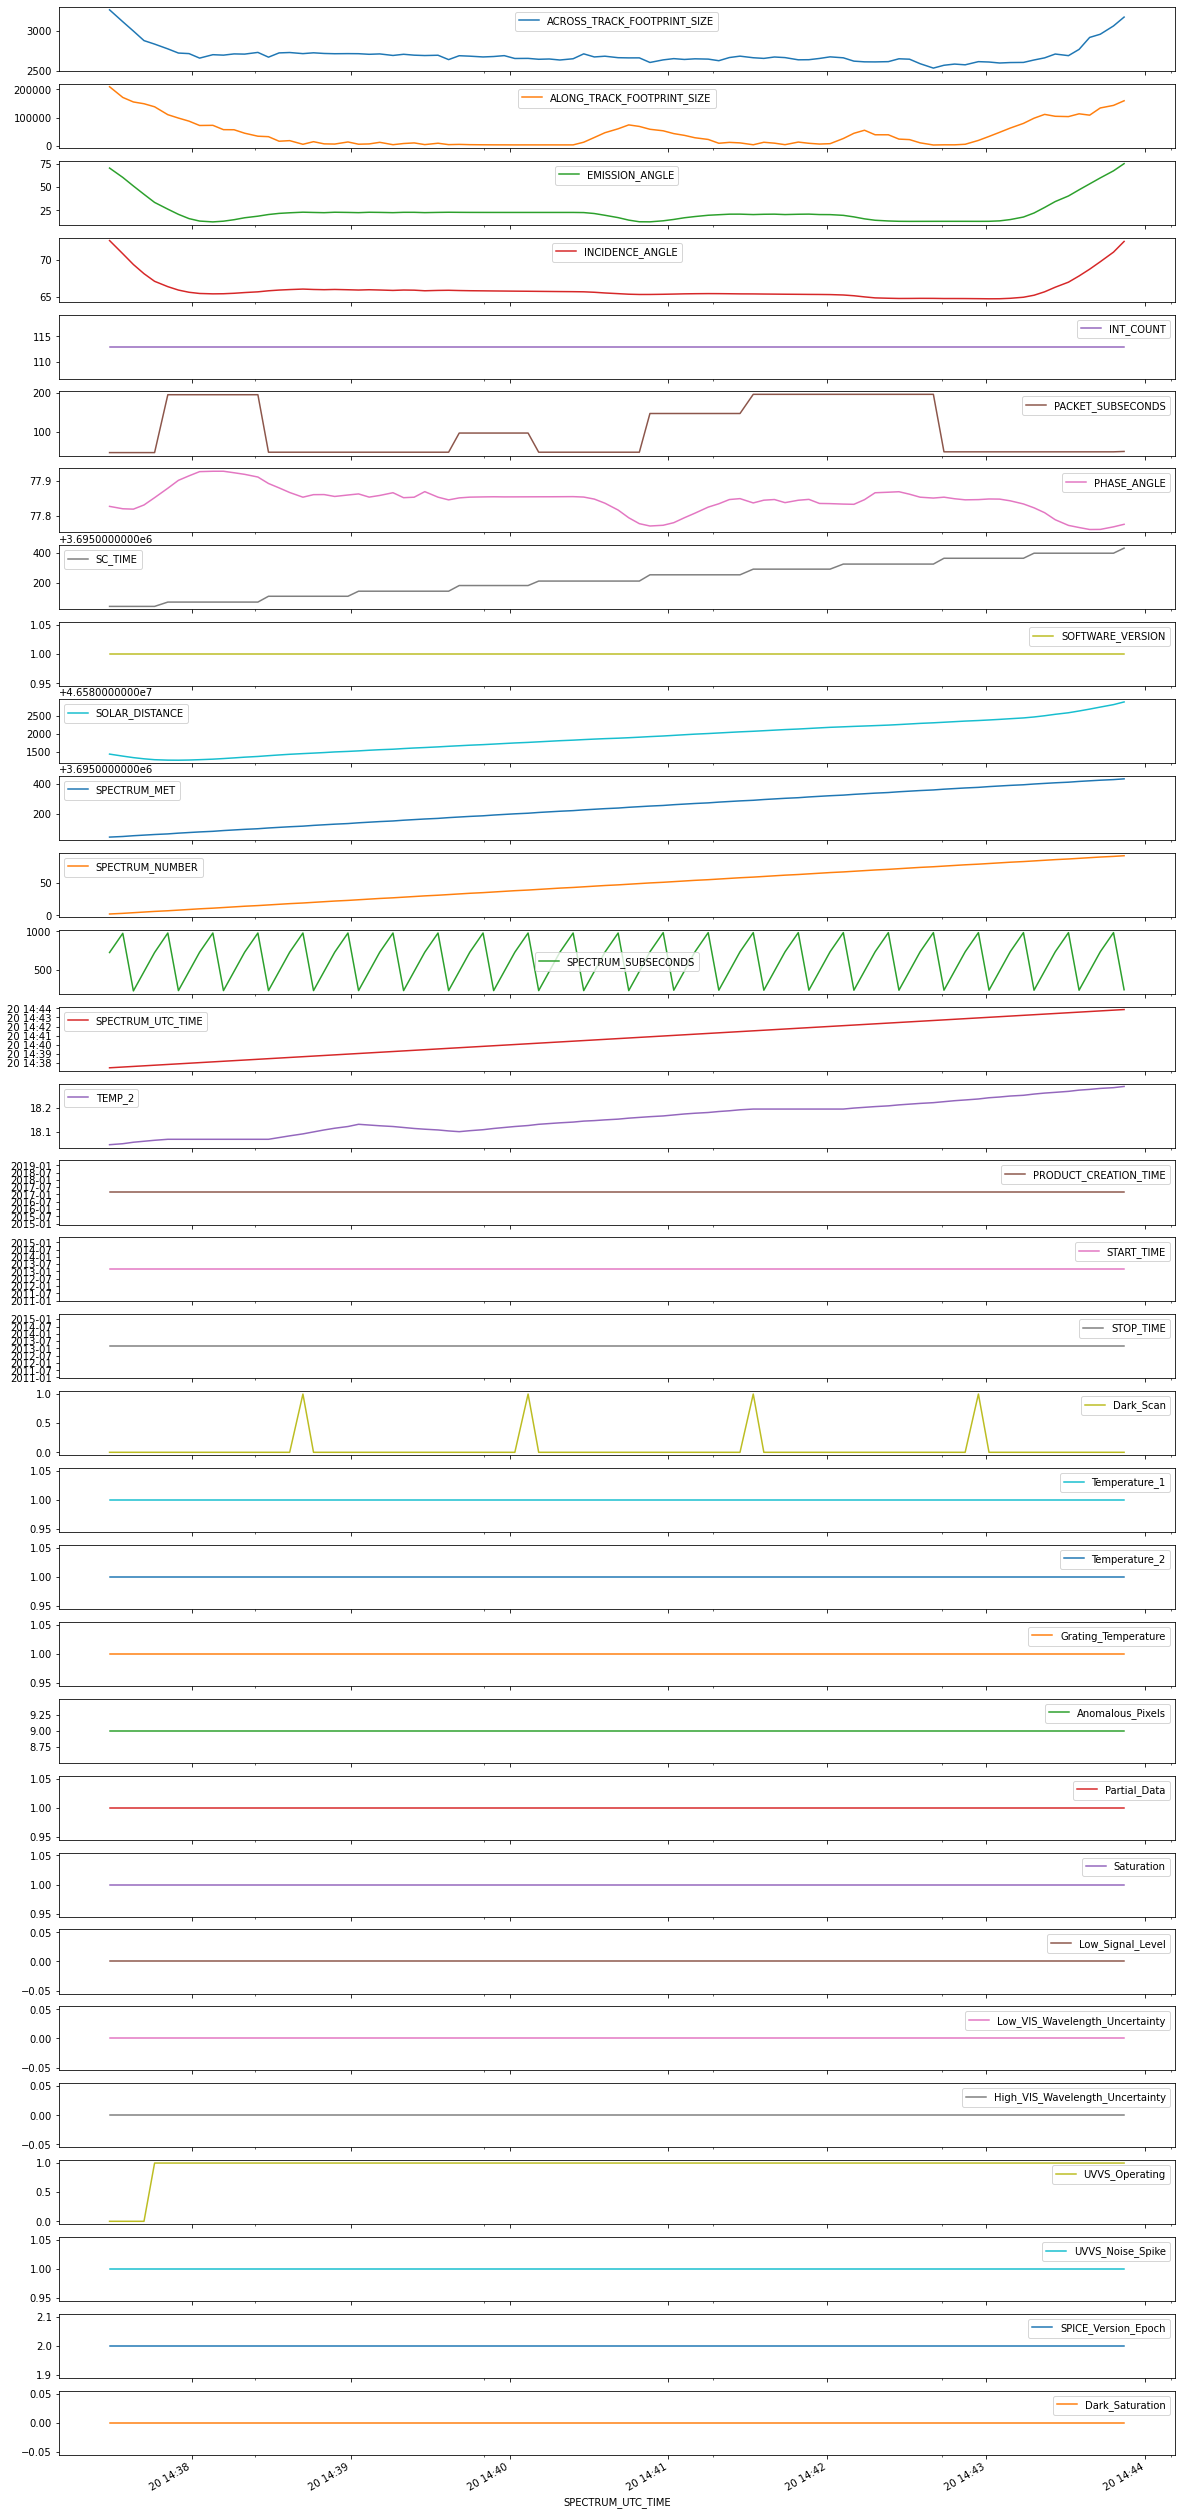

In [19]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

table_df.select_dtypes(exclude='object').plot(subplots=True,figsize=[20,50]);

In [56]:
photom_iof_sp_2nm_df = pd.DataFrame(
    index = wav_grid_2nm.wavelenghts,
    data  = np.transpose([sp['photom_iof_sp_2nm'] for sp in table_data])
)
photom_iof_sp_2nm_df.index.name = 'wavelenghts'

iof_sp_2nm_df = pd.DataFrame(
    index = wav_grid_2nm.wavelenghts,
    data  = np.transpose([sp['iof_sp_2nm'] for sp in table_data])
)
iof_sp_2nm_df.index.name = 'wavelenghts'


In [57]:
print('Photometrically corrected IOF (resampled to 2nm)')
display(photom_iof_sp_2nm_df.loc[264:,].T.head())
print('IOF (resampled to 2nm)')
display(iof_sp_2nm_df.loc[264:,].T.head())


Photometrically corrected IOF (resampled to 2nm)


wavelenghts,264,266,268,270,272,274,276,278,280,282,...,1032,1034,1036,1038,1040,1042,1044,1046,1048,1050
0,0.003844,0.004002,0.005144,0.008322,0.010796,0.00893,0.011833,0.006354,0.007108,0.00862,...,0.117563,0.144318,0.004505,0.101618,0.130817,-0.042874,-0.005571,0.134349,0.206187,0.181259
1,0.004605,0.005509,0.006492,0.009618,0.012767,0.01105,0.0124,0.008232,0.008485,0.010462,...,0.08875,0.098199,0.007452,0.07339,0.131645,-0.00859,0.031645,0.184585,0.267703,0.234446
2,0.002977,0.004008,0.005171,0.006884,0.008576,0.008753,0.009552,0.006443,0.005597,0.007425,...,0.090565,0.090493,0.033011,0.031907,0.077375,-0.057834,-0.070839,0.060081,0.142465,0.101303
3,0.006082,0.006189,0.007638,0.011538,0.014499,0.012459,0.015542,0.010462,0.010798,0.012228,...,0.065517,0.077899,0.022861,0.062532,0.114182,0.009983,0.041713,0.147776,0.211409,0.218133
4,0.002722,0.004472,0.004499,0.006357,0.00956,0.008935,0.009971,0.006298,0.006671,0.007124,...,0.138705,0.101984,0.034259,0.114386,0.120495,-0.017073,-0.023621,0.067427,0.123015,0.116134


IOF (resampled to 2nm)


wavelenghts,264,266,268,270,272,274,276,278,280,282,...,1032,1034,1036,1038,1040,1042,1044,1046,1048,1050
0,0.002744,0.002859,0.003678,0.005955,0.007728,0.006397,0.008482,0.004558,0.005102,0.006191,...,0.074674,0.091645,0.002818,0.064138,0.082352,-0.026843,-0.003551,0.083801,0.128405,0.112524
1,0.003112,0.003724,0.00439,0.006507,0.008639,0.00748,0.008397,0.005576,0.00575,0.007091,...,0.055956,0.061897,0.004679,0.04612,0.082623,-0.005354,0.019781,0.115338,0.167131,0.146143
2,0.00197,0.002654,0.003424,0.004559,0.00568,0.005798,0.006327,0.004268,0.003708,0.00492,...,0.057703,0.057643,0.021016,0.020304,0.049215,-0.036759,-0.045021,0.038141,0.090452,0.064276
3,0.004002,0.004072,0.005025,0.007589,0.009537,0.008195,0.010222,0.006881,0.007101,0.008041,...,0.042412,0.05043,0.014803,0.040493,0.073949,0.006464,0.027024,0.095743,0.136982,0.141358
4,0.001791,0.002943,0.00296,0.004182,0.006288,0.005876,0.006556,0.00414,0.004385,0.004682,...,0.091261,0.067122,0.022569,0.075374,0.079441,-0.011275,-0.015584,0.044541,0.081274,0.076782


In [65]:
photom_iof_sp_2nm_df.mean(axis=1).shape


(396,)

(0.0, 0.1)

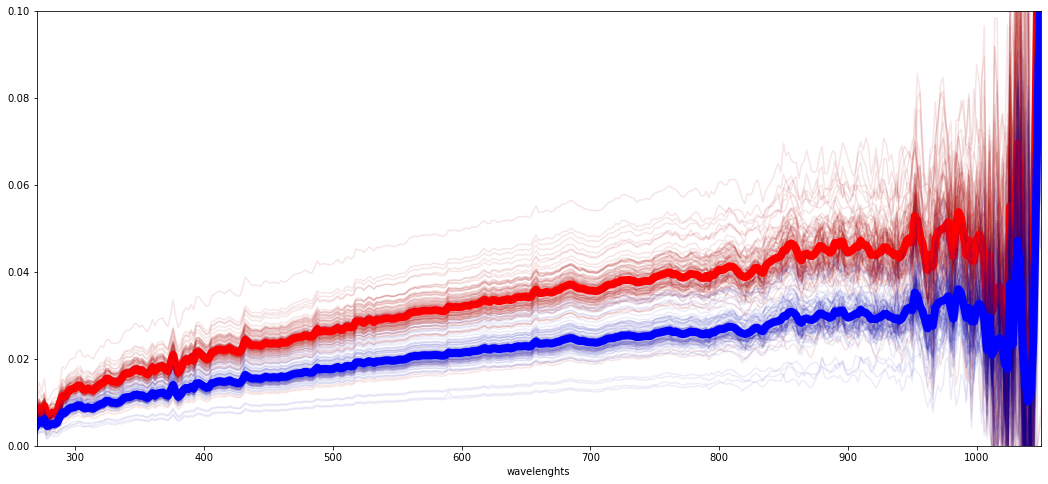

In [77]:
ax = photom_iof_sp_2nm_df.plot(legend=False,color='#aa0000',alpha=.1,figsize=[18,8]);
photom_iof_sp_2nm_df.mean(axis=1).plot(linewidth=8,color='#ff0000',ax=ax)

iof_sp_2nm_df.plot(legend=False,color='#0000aa',alpha=.075,ax=ax);
iof_sp_2nm_df.mean(axis=1).plot(linewidth=8,color='#0000ff',ax=ax)

ax.set_xlim(270,1050)
ax.set_ylim(0.00,0.1)


In [78]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(table_df, geometry='center',crs = {'init': 'epsg:4269'})
gdf[:].plot(column='TEMP_2',figsize=[16,9], cmap='rainbow',legend=True)

/home/kidpixo/miniconda3/envs/datascience/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


TypeError: Input must be valid geometry objects: SRID=4326;POINT (73.09935760498047 6.726365089416504)

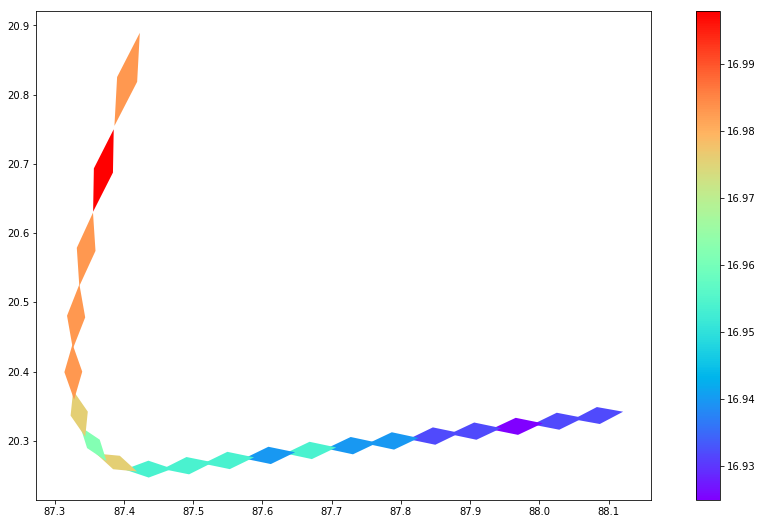

In [34]:
gdf = gpd.GeoDataFrame(table_df, geometry='fov',crs = {'init': 'epsg:4269'})
gdf[780:800].plot(column='TEMP_2',figsize=[16,9], cmap='rainbow',legend=True, lw=4)

In [35]:
find_nearest = lambda array, value : (np.abs(array - value)).argmin()

find_nearest(wav_grid_2nm,750)

245

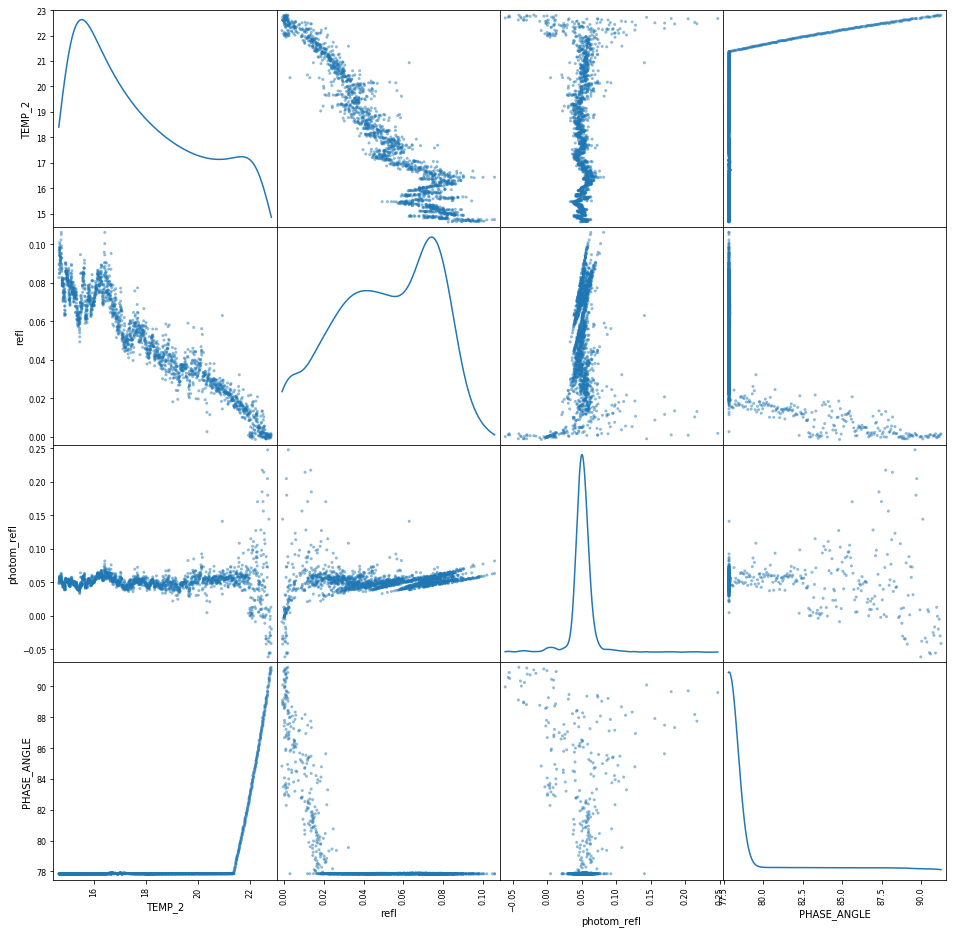

In [36]:
wavelength_idx = find_nearest(wav_grid_2nm,800)

gdf['refl'] = gdf.iof_sp_2nm.apply(lambda x : x[wavelength_idx])
gdf['photom_refl'] = gdf.photom_iof_sp_2nm.apply(lambda x : x[wavelength_idx])
# gdf[['TEMP_2','refl','photom_refl']][gdf['refl'] < 0.3 ].plot.scatter(x='TEMP_2',y='refl', figsize=[20,8])

pd.plotting.scatter_matrix(
    gdf[['TEMP_2','refl','photom_refl', 'PHASE_ANGLE']][
        (gdf['photom_refl'] < 0.25) & (gdf['photom_refl'] > -0.1)
    ],
        figsize=[16,16],
        diagonal='kde');

## Define a DB

In [4]:
from sqlalchemy import create_engine
engine = create_engine(postgresql_connection_string, echo=False)

In [5]:
# declarative_base is used for the mapping local key <> pg columns name

from sqlalchemy import Table, Column, Integer, String, MetaData, Float, DateTime
from geoalchemy2 import Geometry
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.dialects import postgresql

Base = declarative_base(metadata=MetaData())

class MASCSData(Base):
    __tablename__ = 'mascsdata'

    pid = Column(Integer, primary_key=True)
    SOFTWARE_VERSION = Column('software_version',Float)
    SPACECRAFT_CLOCK_START_COUNT = Column('spacecraft_clock_start_count',Float)
    ALONG_TRACK_FOOTPRINT_SIZE = Column('along_track_footprint_size',Float)
    PACKET_SUBSECONDS = Column('packet_subseconds',Integer)
    Partial_Data = Column('partial_data',Integer)
    Temperature_2 = Column('temperature_2',Integer)
    TEMP_2 = Column('temp_2',Float)
    SPICE_Version_Epoch = Column('spice_version_epoch',Integer)
    STANDARD_DATA_PRODUCT_ID = Column('standard_data_product_id',String)
    SPACECRAFT_CLOCK_STOP_COUNT = Column('spacecraft_clock_stop_count',Float)
    Saturation = Column('saturation',Integer)
    START_TIME = Column('start_time',DateTime)
    ACROSS_TRACK_FOOTPRINT_SIZE = Column('across_track_footprint_size',Float)
    Temperature_1 = Column('temperature_1',Integer)
    photom_iof_sp_2nm = Column('photom_iof_sp_2nm', postgresql.ARRAY(Float))
    Low_VIS_Wavelength_Uncertainty = Column('low_vis_wavelength_uncertainty',Integer)
    INCIDENCE_ANGLE = Column('incidence_angle',Float)
    PHASE_ANGLE = Column('phase_angle',Float)
    iof_sp_2nm = Column('iof_sp_2nm', postgresql.ARRAY(Float))
    Anomalous_Pixels = Column('anomalous_pixels',Integer)
    STOP_TIME = Column('stop_time',DateTime)
    Dark_Saturation = Column('dark_saturation',Integer)
    SC_TIME = Column('sc_time',Float)
    UVVS_Noise_Spike = Column('uvvs_noise_spike',Integer)
    SPECTRUM_MET = Column('spectrum_met',Float)
    PRODUCT_ID = Column('product_id',String)
    SPECTRUM_SUBSECONDS = Column('spectrum_subseconds',Integer)
    SPECTRUM_NUMBER = Column('spectrum_number',Integer)
    PRODUCT_CREATION_TIME = Column('product_creation_time',DateTime)
    EMISSION_ANGLE = Column('emission_angle',Float)
    SITE_ID = Column('site_id',String)
    INT_COUNT = Column('int_count',Integer)
    UVVS_Operating = Column('uvvs_operating',Integer)
    DETECTOR_ID = Column('detector_id',String)
    High_VIS_Wavelength_Uncertainty = Column('high_vis_wavelength_uncertainty',Integer)
    SPECTRUM_UTC_TIME = Column('spectrum_utc_time',DateTime)
    SOLAR_DISTANCE = Column('solar_distance',Float)
    TARGET_NAME = Column('target_name',String)
    Low_Signal_Level = Column('low_signal_level',Integer)
    MISSION_PHASE_NAME = Column('mission_phase_name',String)
    PRODUCT_VERSION_ID = Column('product_version_id',String)
    Dark_Scan = Column('dark_scan',Integer)
    DATA_QUALITY_INDEX = Column('data_quality_index',String)
    Grating_Temperature = Column('grating_temperature',Integer)
    fov = Column('fov',Geometry(geometry_type='POLYGON', srid=4326))
    center = Column('center',Geometry(geometry_type='POINT', srid=4326))

    def __repr__(self):
        return "<pid='%s', START_TIME='%s', STOP_TIME='%s'>" % (self.pid, self.START_TIME, self.STOP_TIME)

In [8]:
from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)

In [7]:
Base.metadata.create_all(engine)

In [24]:
from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)

mascsdata_instance = [MASCSData(**tbl) for tbl in table_data]

session = Session()
# session.add(mascsdata_instance[100])
session.add_all(mascsdata_instance)
session.commit()
# {'file':lbl_file.stem,'inserted':len(mascsdata_instance),'last_pk':max([lk.pid for lk in mascsdata_instance])}

In [1]:
%sql postgresql_connection_string

UsageError: Line magic function `%sql` not found.


In [23]:
[lk.pid for lk in mascsdata_instance]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 5,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 N